# Data Generated Analysis

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

GENERATED_ROOT_PATH = os.path.join("..", "input", "bugnet")
GENERATED_PAIRS_PATH = os.path.join(GENERATED_ROOT_PATH, "generated_pairs.csv")
TEST_JSONL_PATH = os.path.join(GENERATED_ROOT_PATH, "Python_test.jsonl")

In [2]:
df = pd.read_csv(GENERATED_PAIRS_PATH)

df.head()

,problem_id,language,original_status,original_src,changed_src,change,i1,i2,j1,j2,error,stderr
0,p00001,Python,Runtime Error,num = [int(input()) for i in range(10)]\nnum.s...,num = [int(input()) for i in range(10)]\nnum.s...,replace,2,3,2,3,TypeError: 'type' object is not subscriptable,"Traceback (most recent call last):\n File ""/h..."
1,p00002,Python,Runtime Error,while True:\n try:\n a = int(input()...,"while True:\n try:\n a, b = map(int,...",replace,2,6,2,5,ValueError: invalid literal for int() with bas...,"Traceback (most recent call last):\n File ""/h..."
2,p00003,Python,Runtime Error,while True:\n try:\n input_line = in...,"n = int(input())\nfor i in range(0, n):\n n...",replace,0,15,0,9,IndexError: list index out of range,"Traceback (most recent call last):\n File ""/h..."
3,p00003,Python,Runtime Error,import sys\n\ninput()\nfor e in sys.stdin:\n ...,import sys\n\ninput()\nfor e in sys.stdin:\n ...,replace,4,5,4,5,"TypeError: int() argument must be a string, a ...","Traceback (most recent call last):\n File ""/h..."
4,p00006,Python,Runtime Error,print(input[::-1])\n,print(input()[::-1])\n,replace,0,1,0,1,TypeError: 'builtin_function_or_method' object...,"Traceback (most recent call last):\n File ""/h..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65186 entries, 0 to 65185
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   problem_id       65186 non-null  object
 1   language         65186 non-null  object
 2   original_status  65186 non-null  object
 3   original_src     65186 non-null  object
 4   changed_src      65186 non-null  object
 5   change           65186 non-null  object
 6   i1               65186 non-null  int64 
 7   i2               65186 non-null  int64 
 8   j1               65186 non-null  int64 
 9   j2               65186 non-null  int64 
 10  error            65186 non-null  object
 11  stderr           3873 non-null   object
dtypes: int64(4), object(8)
memory usage: 6.0+ MB


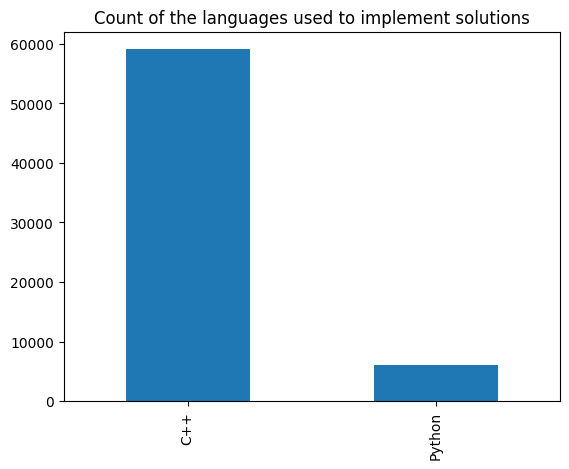

C++       59095
Python     6091
Name: language, dtype: int64

In [4]:
# there are a lot more C++ examples than Python examples
# - how to make the dataset more balanced?

value_counts = df["language"].value_counts()

value_counts.plot.bar()

plt.title("Count of the languages used to implement solutions")
plt.show()

value_counts

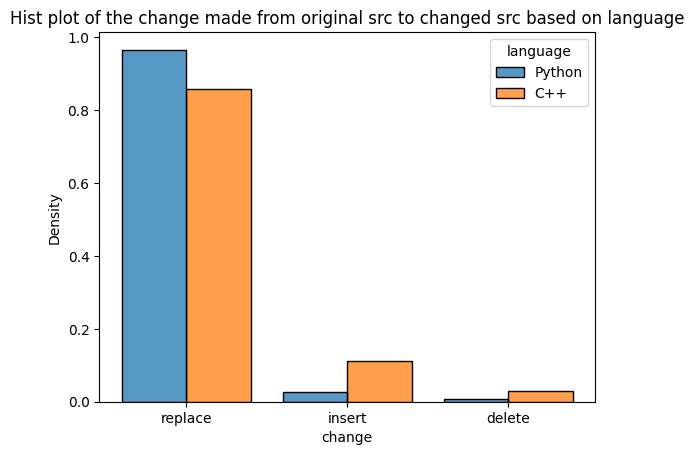

change
language change         
C++      delete     1692
         insert     6651
         replace   50752
Python   delete       44
         insert      165
         replace    5882

In [5]:
# the distribution of the changes made is similar between the two languages
# even though the number of examples is very different; the replace example
# is more interesting than the others; insert is also a bit interesting;
# delete is the least interesting because it doesn't require the model
# generate any code;

sns.histplot(x=df["change"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Hist plot of the change made from original src to changed src based on language")
plt.show()

df.groupby(["language", "change"]).agg({"change": "count"})

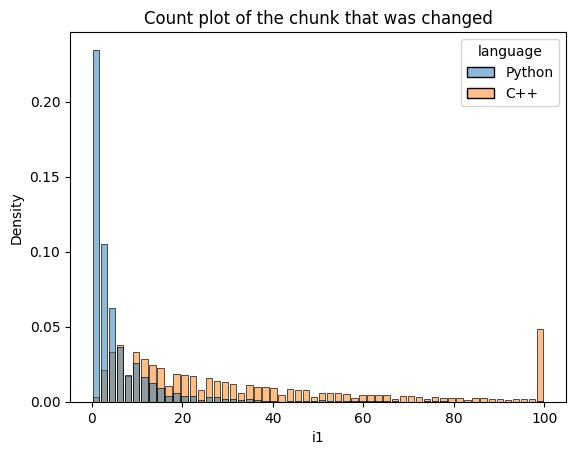

In [6]:
# most of the bugs happened in the beginning of the file; the plot
# displays the start line of the chunk that is buggy; it seems that
# for C++ there are some examples where the source code was very long;
# but for Python, most bugs occured on the first/second lines;

x = df["i1"].map(lambda line: line if line < 100 else 100)
sns.histplot(x=x, hue=df["language"], stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the chunk that was changed")
plt.show()

The maximum size of a chunk is 215


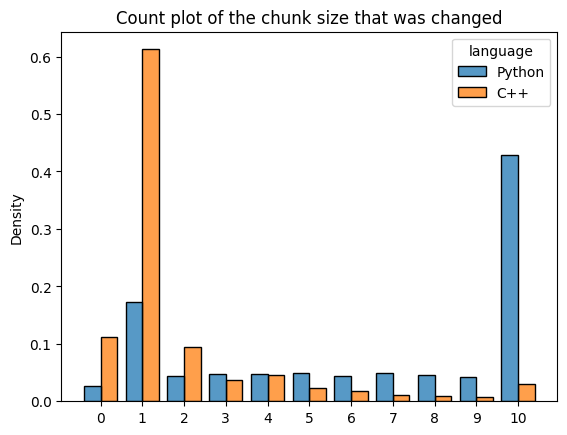

In [7]:
# the size of the chunks seems to be pretty constant; the most common
# size for a chunk is one; this means only one line change; this happens
# to be almost half of the samples; there are some zero lines changes,
# those are the insert changes; those require code to just be generated
# and do not require modifications, just insertion;

x = (df["i2"] - df["i1"])
x_cap = x.map(lambda line: line if line < 10 else 10).astype("category")

sns.histplot(x=x_cap, hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)
plt.xticks(list(range(11)))

print(f"The maximum size of a chunk is {x.max()}")

plt.title("Count plot of the chunk size that was changed")
plt.show()

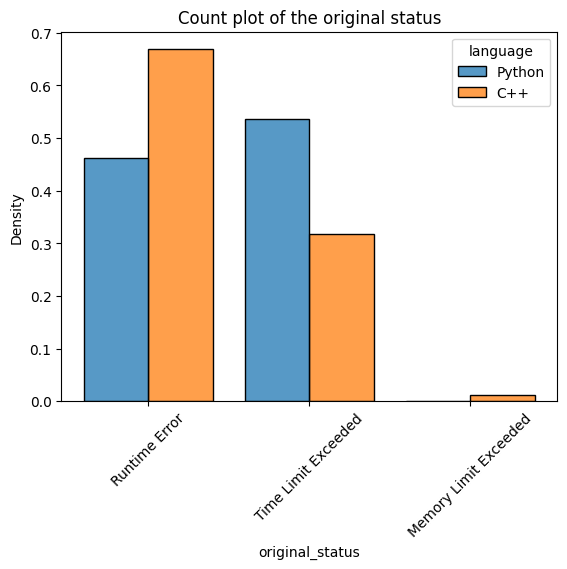

original_status
language original_status                       
C++      Memory Limit Exceeded              744
         Runtime Error                    39514
         Time Limit Exceeded              18837
Python   Memory Limit Exceeded                5
         Runtime Error                     2814
         Time Limit Exceeded               3272

In [8]:
# the type of error from the original dataset (original status);
# very few examples with MLE, but there are a decent amount of TLE bugs;
# most of the bugs are Runtime Errors;

sns.histplot(x=df["original_status"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the original status")
plt.xticks(rotation=45)
plt.show()

df.groupby(["language", "original_status"]).agg({"original_status": "count"})

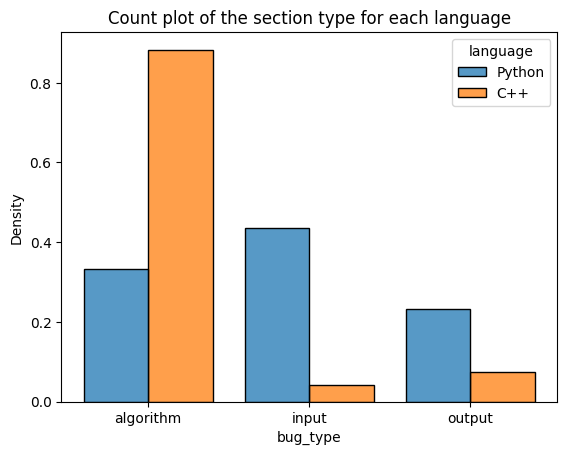

In [9]:
# very simple way of deciding if the bug is related to input is to check if
# the usual functions for reading for each language are in the changed
# source code (accepted); we can do the same for output; and we can consider
# the rest as algorithm; pretty dumb, but it can work at some extent; maybe
# try to do this better?
# obviously most of the bugs are in the algorithm category; for Python there
# are also a lot of input examples (and also output); C++ has a lot more
# examples in the algorithm category than Python;

def get_bug_type(row: pd.Series) -> str:
    line = "\n".join(row["changed_src"].splitlines()[row["j1"]:row["j2"]])
    language = row["language"]

    if language == "Python":
        return (
            "input"
            if "input" in line
            else "output"
            if "print" in line
            else "algorithm"
        )

    if language == "C++":
        return (
            "input"
            if ("cin" in line or "scanf" in line)
            else "output"
            if ("cout" in line or "printf" in line)
            else "algorithm"
        )

    raise NotImplementedError(f"{language} not implemented yet")

df["bug_type"] = df.apply(get_bug_type, axis="columns")

sns.histplot(x=df["bug_type"], hue=df["language"], multiple="dodge", 
             stat="density", shrink=0.8, common_norm=False)

plt.title("Count plot of the section type for each language")
plt.show()

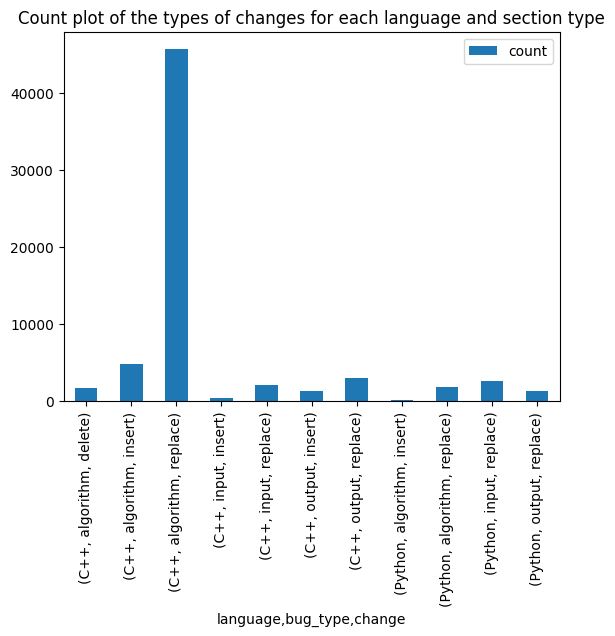

count
language bug_type  change        
C++      algorithm delete    1692
                   insert    4852
                   replace  45655
         input     insert     409
                   replace   2113
         output    insert    1390
                   replace   2984
Python   algorithm insert     125
                   replace   1850
         input     replace   2651
         output    replace   1381

In [10]:
# most of the algorithm changes are replace modifications; there are some
# deletes for C++ (only C++ algorithm); Python has mostly replace changes;

agg_df = df.groupby(["language", "bug_type", "change"]).agg({"change": "count"})
agg_df = agg_df[agg_df["change"] > 100]
agg_df.columns = ["count"]

agg_df.plot.bar()

plt.title("Count plot of the types of changes for each language and section type")
plt.show()

agg_df

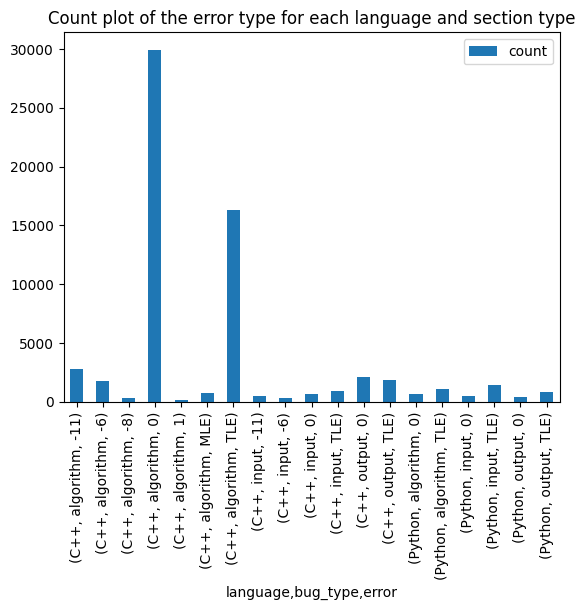

count
language bug_type  error       
C++      algorithm -11     2813
                   -6      1807
                   -8       358
                   0      29932
                   1        132
                   MLE      724
                   TLE    16293
         input     -11      482
                   -6       363
                   0        697
                   TLE      912
         output    0       2090
                   TLE     1857
Python   algorithm 0        625
                   TLE     1076
         input     0        473
                   TLE     1467
         output    0        404
                   TLE      836

In [11]:
# there are some 0 return code examples, but it is what it is, we don't have
# all test cases; for C++ most algorithm bugs happen because of TLE and there
# are also some that fail because of segfault (-11); for C++ input, it is 
# very similar, with more TLE and some segfaults, but this time the count 
# is more balanced; for C++ output most bugs happen because of TLE; it looks like
# the most bugs for C++ happen because of TLE; the ones that resulted in Runtime
# Error (which previously we seen that is the majoritary class) have a return code
# of 0 (maybe missing test cases); Python is similar, it has mostly TLE bugs; but
# for reading input it has some TypeError and ValueError (maybe converting gone wrong)

agg_df = df.groupby(["language", "bug_type", "error"]).agg({"change": "count"})
agg_df = agg_df[agg_df["change"] > 100]
agg_df.columns = ["count"]

agg_df.plot.bar()

plt.title("Count plot of the error type for each language and section type")
plt.show()

agg_df

In [12]:
# correlation between the bug type and error type;
# idk what this shows, seems like there is not that much correlation;
# between the error type and the bug section type;
# there is more correlation between the error type and the original status
# which makes sense I guess;

df["bug_type_cat"]=df["bug_type"].astype("category").cat.codes
df["error_cat"]=df["error"].astype("category").cat.codes
df["original_status_cat"]=df["original_status"].astype("category").cat.codes

corr = df.groupby("language")[["bug_type_cat", "error_cat", "original_status_cat"]].corr()

print("Correlation of error and bug type")
corr.style.background_gradient(cmap='coolwarm')

Correlation of error and bug type


In [13]:
# Check the bug type distribution of the test set

def get_bug_type(row: pd.Series) -> str:
    line = "\n".join(row["changed_src"].splitlines()[row["j1"] : row["j2"]])
    language = row["language"]

    if language == "Python":
        return (
            "input"
            if "input" in line
            else "output"
            if "print" in line
            else "algorithm"
        )

    if language == "C++":
        return (
            "input"
            if ("cin" in line or "scanf" in line)
            else "output"
            if ("cout" in line or "printf" in line)
            else "algorithm"
        )

    raise NotImplementedError(f"{language} not implemented yet")

In [14]:
df = pd.read_json(TEST_JSONL_PATH, lines=True)

df["type"] = df.apply(get_bug_type, axis="columns")

df.head()

,problem_id,language,original_status,original_src,changed_src,change,i1,i2,j1,j2,error,stderr,type
0,p00001,Python,Runtime Error,num = [int(input()) for i in range(10)]\nnum.s...,num = [int(input()) for i in range(10)]\nnum.s...,replace,2,3,2,3,TypeError: 'type' object is not subscriptable,"Traceback (most recent call last):\n File ""/h...",algorithm
1,p00002,Python,Runtime Error,while True:\n try:\n a = int(input()...,"while True:\n try:\n a, b = map(int,...",replace,2,6,2,5,ValueError: invalid literal for int() with bas...,"Traceback (most recent call last):\n File ""/h...",input
2,p00003,Python,Runtime Error,while True:\n try:\n input_line = in...,"n = int(input())\nfor i in range(0, n):\n n...",replace,0,15,0,9,IndexError: list index out of range,"Traceback (most recent call last):\n File ""/h...",input
3,p00003,Python,Runtime Error,import sys\n\ninput()\nfor e in sys.stdin:\n ...,import sys\n\ninput()\nfor e in sys.stdin:\n ...,replace,4,5,4,5,"TypeError: int() argument must be a string, a ...","Traceback (most recent call last):\n File ""/h...",algorithm
4,p00006,Python,Runtime Error,print(input[::-1])\n,print(input()[::-1])\n,replace,0,1,0,1,TypeError: 'builtin_function_or_method' object...,"Traceback (most recent call last):\n File ""/h...",input


In [15]:
lang_df = df.groupby(["language", "type"])["type"].count()

print("Bug types in test")
lang_df

Bug types in test


language  type     
Python    algorithm    16
          input        72
          output       12
Name: type, dtype: int64